In [72]:
from sklearn.datasets import *
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle as util_shuffle
from sklearn.utils.random import sample_without_replacement
import numpy as np

def _generate_hypercube(samples, dimensions, rng):
    """Returns distinct binary samples of length dimensions."""
    if dimensions > 30:
        return np.hstack(
            [
                rng.randint(2, size=(samples, dimensions - 30)),
                _generate_hypercube(samples, 30, rng),
            ]
        )
    out = sample_without_replacement(2**dimensions, samples, random_state=rng).astype(
        dtype=">u4", copy=False
    )
    out = np.unpackbits(out.view(">u1")).reshape((-1, 32))[:, -dimensions:]
    return out

def make_classification(
    n_samples=100,
    n_features=20,
    *,
    n_informative=2,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights=None,
    flip_y=0.01,
    class_sep=1.0,
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=True,
    random_state=None,
):
    """Generate a random n-class classification problem.
    This initially creates clusters of points normally distributed (std=1)
    about vertices of an ``n_informative``-dimensional hypercube with sides of
    length ``2*class_sep`` and assigns an equal number of clusters to each
    class. It introduces interdependence between these features and adds
    various types of further noise to the data.
    Without shuffling, ``X`` horizontally stacks features in the following
    order: the primary ``n_informative`` features, followed by ``n_redundant``
    linear combinations of the informative features, followed by ``n_repeated``
    duplicates, drawn randomly with replacement from the informative and
    redundant features. The remaining features are filled with random noise.
    Thus, without shuffling, all useful features are contained in the columns
    ``X[:, :n_informative + n_redundant + n_repeated]``.
    Read more in the :ref:`User Guide <sample_generators>`.
    Parameters
    ----------
    n_samples : int, default=100
        The number of samples.
    n_features : int, default=20
        The total number of features. These comprise ``n_informative``
        informative features, ``n_redundant`` redundant features,
        ``n_repeated`` duplicated features and
        ``n_features-n_informative-n_redundant-n_repeated`` useless features
        drawn at random.
    n_informative : int, default=2
        The number of informative features. Each class is composed of a number
        of gaussian clusters each located around the vertices of a hypercube
        in a subspace of dimension ``n_informative``. For each cluster,
        informative features are drawn independently from  N(0, 1) and then
        randomly linearly combined within each cluster in order to add
        covariance. The clusters are then placed on the vertices of the
        hypercube.
    n_redundant : int, default=2
        The number of redundant features. These features are generated as
        random linear combinations of the informative features.
    n_repeated : int, default=0
        The number of duplicated features, drawn randomly from the informative
        and the redundant features.
    n_classes : int, default=2
        The number of classes (or labels) of the classification problem.
    n_clusters_per_class : int, default=2
        The number of clusters per class.
    weights : array-like of shape (n_classes,) or (n_classes - 1,),\
              default=None
        The proportions of samples assigned to each class. If None, then
        classes are balanced. Note that if ``len(weights) == n_classes - 1``,
        then the last class weight is automatically inferred.
        More than ``n_samples`` samples may be returned if the sum of
        ``weights`` exceeds 1. Note that the actual class proportions will
        not exactly match ``weights`` when ``flip_y`` isn't 0.
    flip_y : float, default=0.01
        The fraction of samples whose class is assigned randomly. Larger
        values introduce noise in the labels and make the classification
        task harder. Note that the default setting flip_y > 0 might lead
        to less than ``n_classes`` in y in some cases.
    class_sep : float, default=1.0
        The factor multiplying the hypercube size.  Larger values spread
        out the clusters/classes and make the classification task easier.
    hypercube : bool, default=True
        If True, the clusters are put on the vertices of a hypercube. If
        False, the clusters are put on the vertices of a random polytope.
    shift : float, ndarray of shape (n_features,) or None, default=0.0
        Shift features by the specified value. If None, then features
        are shifted by a random value drawn in [-class_sep, class_sep].
    scale : float, ndarray of shape (n_features,) or None, default=1.0
        Multiply features by the specified value. If None, then features
        are scaled by a random value drawn in [1, 100]. Note that scaling
        happens after shifting.
    shuffle : bool, default=True
        Shuffle the samples and the features.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Returns
    -------
    X : ndarray of shape (n_samples, n_features)
        The generated samples.
    y : ndarray of shape (n_samples,)
        The integer labels for class membership of each sample.
    See Also
    --------
    make_blobs : Simplified variant.
    make_multilabel_classification : Unrelated generator for multilabel tasks.
    Notes
    -----
    The algorithm is adapted from Guyon [1] and was designed to generate
    the "Madelon" dataset.
    References
    ----------
    .. [1] I. Guyon, "Design of experiments for the NIPS 2003 variable
           selection benchmark", 2003.
    """
    generator = check_random_state(random_state)

    # Count features, clusters and samples
    if n_informative + n_redundant + n_repeated > n_features:
        raise ValueError(
            "Number of informative, redundant and repeated "
            "features must sum to less than the number of total"
            " features"
        )
    # Use log2 to avoid overflow errors
    if n_informative < np.log2(n_classes * n_clusters_per_class):
        msg = "n_classes({}) * n_clusters_per_class({}) must be"
        msg += " smaller or equal 2**n_informative({})={}"
        raise ValueError(
            msg.format(
                n_classes, n_clusters_per_class, n_informative, 2**n_informative
            )
        )

    if weights is not None:
        if len(weights) not in [n_classes, n_classes - 1,n_classes*n_clusters_per_class]:
            raise ValueError(
                "Weights specified but incompatible with number of classes."
            )
        if len(weights) == n_classes*n_clusters_per_class:
            print("Received weights for each of the clusters")
        elif len(weights) == n_classes - 1:
            if isinstance(weights, list):
                weights = weights + [1.0 - sum(weights)]
            else:
                weights = np.resize(weights, n_classes)
                weights[-1] = 1.0 - sum(weights[:-1])
    else:
        weights = [1.0 / n_classes] * n_classes

    n_useless = n_features - n_informative - n_redundant - n_repeated
    n_clusters = n_classes * n_clusters_per_class

    # Distribute samples among clusters by weight
    if len(weights)==n_classes:
        n_samples_per_cluster = [
            int(n_samples * weights[k % n_classes] / n_clusters_per_class)
            for k in range(n_clusters)
        ]
    else:
        n_samples_per_cluster = [
            int(n_samples * weights[k])
            for k in range(n_clusters)
        ]
        print("n_samples_per_cluster",n_samples_per_cluster)

    for i in range(n_samples - sum(n_samples_per_cluster)):
        n_samples_per_cluster[i % n_clusters] += 1

    # Initialize X and y
    X = np.zeros((n_samples, n_features))
    y = np.zeros(n_samples, dtype=int)

    # Build the polytope whose vertices become cluster centroids
    centroids = _generate_hypercube(n_clusters, n_informative, generator).astype(
        float, copy=False
    )
    centroids *= 2 * class_sep
    centroids -= class_sep
    if not hypercube:
        centroids *= generator.uniform(size=(n_clusters, 1))
        centroids *= generator.uniform(size=(1, n_informative))

    # Initially draw informative features from the standard normal
    X[:, :n_informative] = generator.standard_normal(size=(n_samples, n_informative))

    # Create each cluster; a variant of make_blobs
    stop = 0
    for k, centroid in enumerate(centroids):
        start, stop = stop, stop + n_samples_per_cluster[k]
        y[start:stop] = k % n_classes  # assign labels
        X_k = X[start:stop, :n_informative]  # slice a view of the cluster

        A = 2 * generator.uniform(size=(n_informative, n_informative)) - 1
        X_k[...] = np.dot(X_k, A)  # introduce random covariance

        X_k += centroid  # shift the cluster to a vertex

    # Create redundant features
    if n_redundant > 0:
        B = 2 * generator.uniform(size=(n_informative, n_redundant)) - 1
        X[:, n_informative : n_informative + n_redundant] = np.dot(
            X[:, :n_informative], B
        )

    # Repeat some features
    if n_repeated > 0:
        n = n_informative + n_redundant
        indices = ((n - 1) * generator.uniform(size=n_repeated) + 0.5).astype(np.intp)
        X[:, n : n + n_repeated] = X[:, indices]

    # Fill useless features
    if n_useless > 0:
        X[:, -n_useless:] = generator.standard_normal(size=(n_samples, n_useless))

    # Randomly replace labels
    if flip_y >= 0.0:
        flip_mask = generator.uniform(size=n_samples) < flip_y
        y[flip_mask] = generator.randint(n_classes, size=flip_mask.sum())

    # Randomly shift and scale
    if shift is None:
        shift = (2 * generator.uniform(size=n_features) - 1) * class_sep
    X += shift

    if scale is None:
        scale = 1 + 100 * generator.uniform(size=n_features)
    X *= scale

    if shuffle:
        # Randomly permute samples
        util_shuffle(X, y, random_state=generator)

        # Randomly permute features
        indices = np.arange(n_features)
        generator.shuffle(indices)
        X[:, :] = X[:, indices]

    return X, y,n_samples_per_cluster

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

seed = 2040


def create_dataset(n_clusters_per_class, class_sep=2,weights=None, seed=2032, return_clusters = False):
    X, y,clusters = make_classification(n_samples=1000,n_features=2, n_redundant=0, n_informative=2, weights=weights,n_clusters_per_class=n_clusters_per_class,random_state=seed,class_sep=class_sep)
    result = pd.DataFrame(data={"x1":X[:,0],"x2":X[:,1],"y":y})
    if return_clusters:
        return result, clusters
    else:
        return result


def plot_logisticregression(clf,dataset,ax,plotx):
    axs = ax[0][plotx]
    
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    sns.lineplot(x=xx, y=yy,linewidth=1.5,linestyle='--', color='black',ax=axs)
    sns.scatterplot(data=dataset, x="x1", y="x2",hue="y",ax=axs)
    axs.set(aspect="equal",xlim=(-5, 5), ylim=(-5, 5),xlabel="$X_1$", ylabel="$X_2$")
    axs.get_legend().remove()


    axs = ax[1][plotx]
    axs.set(ylim=(-5, 5),xlim=(-5,5))
    axs.set(aspect="equal",xlim=(-5, 5), ylim=(-5, 5),xlabel="$X_1$", ylabel="$X_2$")
    sns.lineplot(x=xx, y=yy,linewidth=1.5,linestyle='--', color='black',ax=axs)
    sns.kdeplot(
        data=dataset, x="x1", y="x2", hue="y", fill=True,ax=axs
    )

    axs.get_legend().remove()

## Generate covariate shift

Received weights for each of the clusters
n_samples_per_cluster [250, 250, 250, 250]
Received weights for each of the clusters
n_samples_per_cluster [50, 50, 450, 450]
Received weights for each of the clusters
n_samples_per_cluster [20, 480, 480, 20]


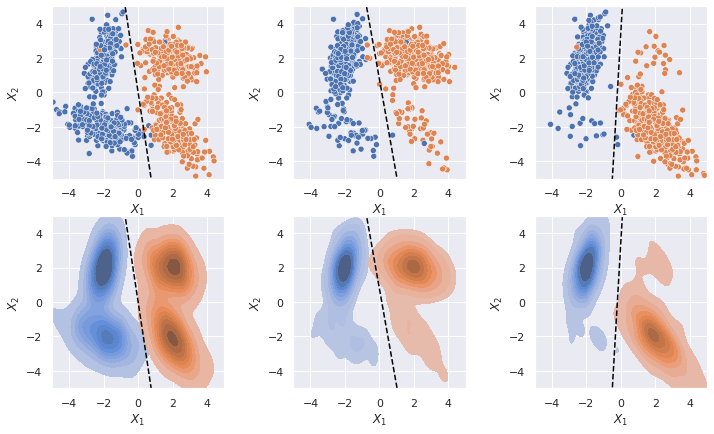

In [74]:
sns.set_theme()
f, ax = plt.subplots(2,3,figsize=(10, 6))
f.tight_layout()
f.subplots_adjust(wspace=0.4)

dataset = create_dataset(2,weights=[0.25,0.25,0.25,0.25],seed=seed)
clf = LogisticRegression().fit(dataset[['x1', 'x2']], dataset['y'])
plot_logisticregression(clf,dataset,ax,0)

dataset = create_dataset(2,weights=[0.05,0.05,0.45,0.45],seed=seed)
clf = LogisticRegression().fit(dataset[['x1', 'x2']], dataset['y'])
plot_logisticregression(clf,dataset,ax,1)

dataset = create_dataset(2,weights=[0.02,0.48,0.48,0.02],seed=seed)
clf = LogisticRegression().fit(dataset[['x1', 'x2']], dataset['y'])
plot_logisticregression(clf,dataset,ax,2)

plt.savefig('images/covariatedrawing.pdf',format='pdf')
plt.savefig('images/covariatedrawing.png',format='png')

## Generate prior probability shift

Received weights for each of the clusters
Received weights for each of the clusters
Received weights for each of the clusters


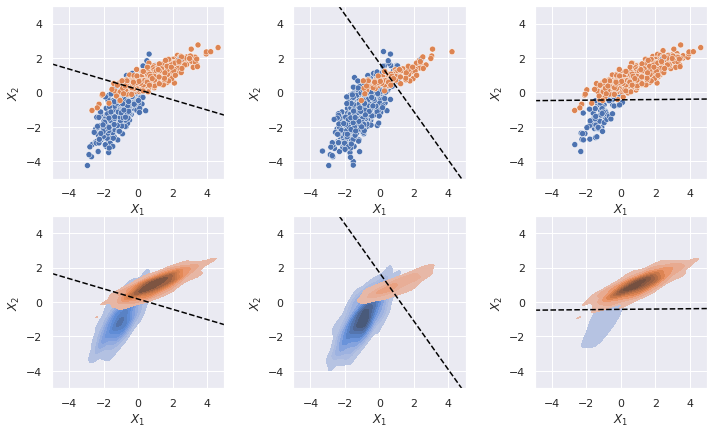

In [75]:
class_sep=1
seed= 16

f, ax = plt.subplots(2,3,figsize=(10, 6))
f.tight_layout()
f.subplots_adjust(wspace=0.4)

dataset = create_dataset(1,weights=[0.5,0.5],seed=seed,class_sep=class_sep)
clf = LogisticRegression().fit(dataset[['x1', 'x2']], dataset['y'])
plot_logisticregression(clf,dataset,ax,0)

dataset = create_dataset(1,weights=[0.9,0.1],seed=seed,class_sep=class_sep)
clf = LogisticRegression().fit(dataset[['x1', 'x2']], dataset['y'])
plot_logisticregression(clf,dataset,ax,1)

dataset = create_dataset(1,weights=[0.1,0.9],seed=seed,class_sep=class_sep)
clf = LogisticRegression().fit(dataset[['x1', 'x2']], dataset['y'])
plot_logisticregression(clf,dataset,ax,2)

plt.savefig('images/priordrawing.pdf',format='pdf')
plt.savefig('images/priordrawing.png',format='png')


## Generate concept shift
We are going to shift some of the points

Received weights for each of the clusters
n_samples_per_cluster [250, 250, 250, 250]
[250, 250, 250, 250]


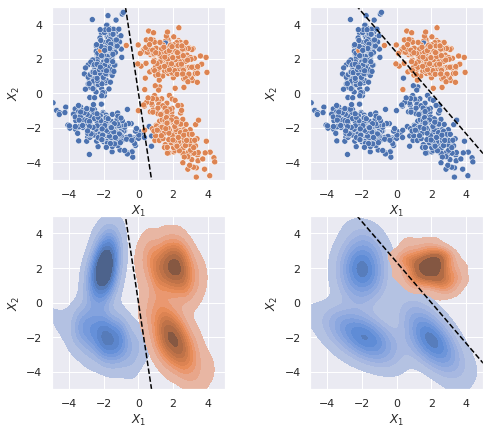

In [76]:
seed = 2040

f, ax = plt.subplots(2,2,figsize=(7, 6))
f.tight_layout()
f.subplots_adjust(wspace=0.4)

dataset, clusters = create_dataset(2,weights=[0.25,0.25,0.25,0.25],seed=seed,return_clusters=True)
clf = LogisticRegression().fit(dataset[['x1', 'x2']], dataset['y'])
plot_logisticregression(clf,dataset,ax,0)
#Modify one cluster
cluster_to_modify = 1
start_idx = 0
print(clusters)
for c in clusters[0:cluster_to_modify]:
    start_idx += c 
end_idx = start_idx+clusters[cluster_to_modify]-1

dataset.loc[start_idx:end_idx,'y']=0

clf = LogisticRegression().fit(dataset[['x1', 'x2']], dataset['y'])
plot_logisticregression(clf,dataset,ax,1)

plt.savefig('images/conceptdrawing.pdf',format='pdf')
plt.savefig('images/conceptdrawing.png',format='png')